# Mac Address Analysis

The mac addresss can be used to understand the type of devices held by the customer. A csv was downloaded from the official IEEE website which contains a list of the first 6 letters of the mac address and the company which they are associated with.

In [115]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
matplotlib.style.use('ggplot')

from msci.cleaning.clean_data import remove_sparse_data

## Import the data and the mac addresses

In [3]:
COLUMNS_TO_IMPORT = ['mac_address', 'date_time', 'location', 'store_id', 'x', 'y']

shopper_df = pd.read_csv('../data/bag_mus_12-22-2016.csv', usecols=COLUMNS_TO_IMPORT)
shopper_df.date_time = shopper_df.date_time.astype('datetime64[ns]')

# signal_df = shopper_df[shopper_df['location'] == 'Home & Leisure']
signal_df = shopper_df[shopper_df['location'] == 'Mall of Mauritius']
# signal_df = shopper_df[shopper_df['location'] == 'Phoenix Mall']

In [4]:
mac_address_cross_reference_df = pd.read_csv('../data/mac_address_cross_reference.csv')

## Add manufacturer to signal_df

In [5]:
signal_df['mac_address_short'] = signal_df.mac_address.str.replace(':', '').str.upper().str[:6]
signal_df = signal_df.merge(mac_address_cross_reference_df, how='left', left_on='mac_address_short', right_on='Assignment')
signal_df.drop(['Registry', 'Assignment', 'Organization Address'], inplace=True, axis=1)
signal_df.rename(columns={'Organization Name': 'manufacturer'}, inplace=True)

c:\users\tvb\envs\venv-msci\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Manufacturer Analysis

In [6]:
signal_df.manufacturer.value_counts()[:30]

Samsung Electronics Co.,Ltd                                       791155
Apple, Inc.                                                       261269
HUAWEI TECHNOLOGIES CO.,LTD                                       194784
SAMSUNG ELECTRO-MECHANICS(THAILAND)                               162656
HTC Corporation                                                   142012
LG Electronics (Mobile Communications)                            108320
Murata Manufacturing Co., Ltd.                                     56911
Intel Corporate                                                    54493
Ruckus Wireless                                                    53352
Sony Mobile Communications AB                                      47437
Hon Hai Precision Ind. Co.,Ltd.                                    35920
Xiaomi Communications Co Ltd                                       33643
TCT mobile ltd                                                     25138
Microsoft Corporation                              

In [7]:
signal_df.groupby('mac_address').head(1).manufacturer.value_counts()[:30]

Samsung Electronics Co.,Ltd                                       17575
Apple, Inc.                                                        4727
SAMSUNG ELECTRO-MECHANICS(THAILAND)                                4649
HUAWEI TECHNOLOGIES CO.,LTD                                        3687
HTC Corporation                                                    3123
Motorola Mobility LLC, a Lenovo Company                            2769
LG Electronics (Mobile Communications)                             2754
Murata Manufacturing Co., Ltd.                                     1681
Sony Mobile Communications AB                                      1184
Nokia Corporation                                                   720
Microsoft Corporation                                               658
SAMSUNG ELECTRO MECHANICS CO., LTD.                                 571
TCT mobile ltd                                                      419
Ubiquiti Networks Inc.                                          

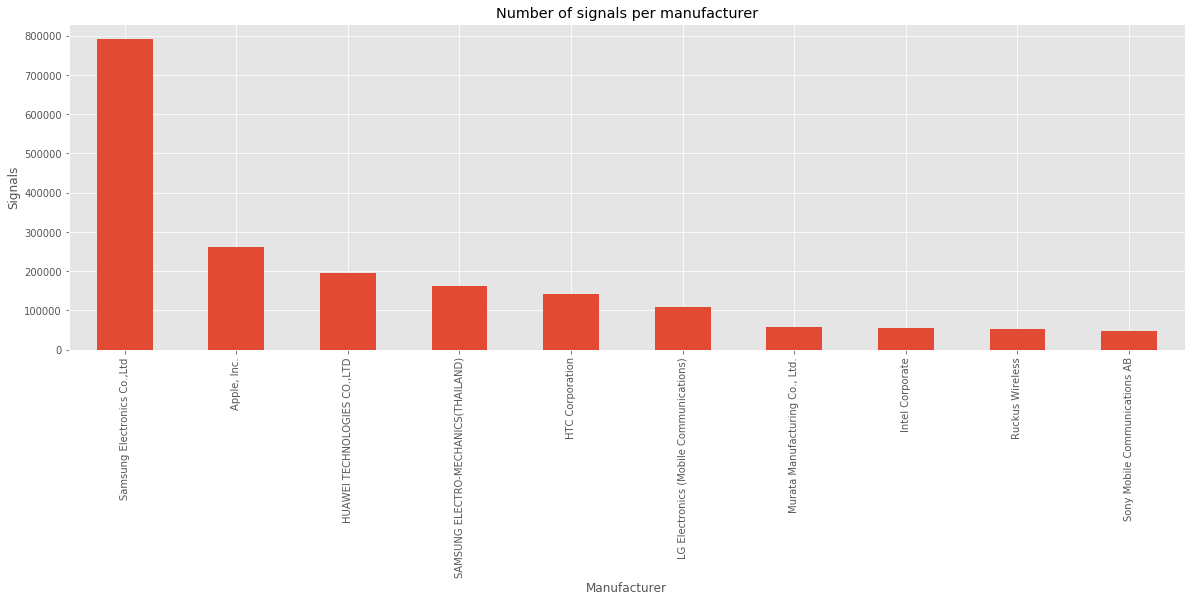

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
ax = signal_df.manufacturer.value_counts()[0:10].plot.bar(ax=axes)
ax.set_title('Number of signals per manufacturer')
ax.set_xlabel('Manufacturer')
ax.set_ylabel('Signals');

### Number of signals against time

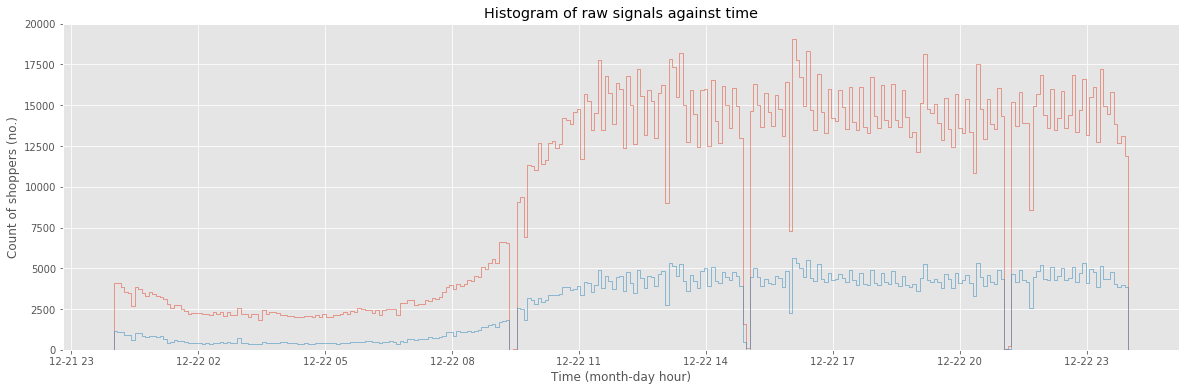

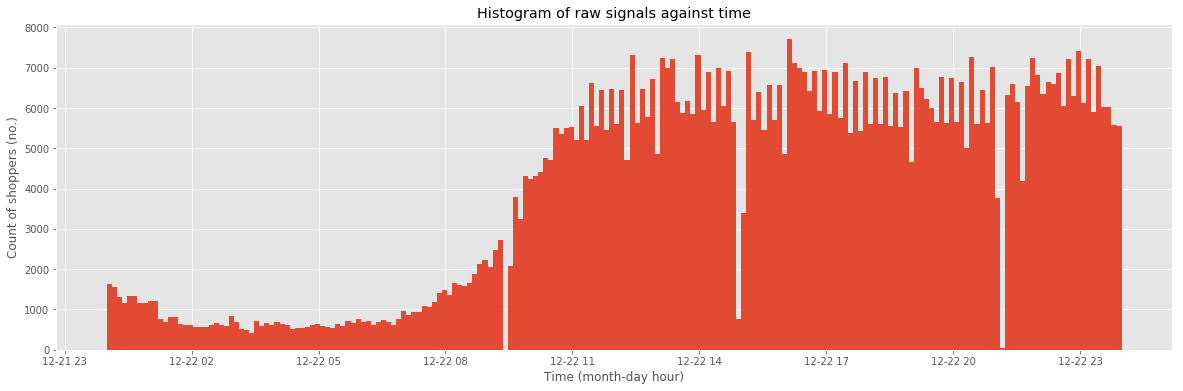

In [9]:
COMPANY = 'Samsung Electronics Co.,Ltd'

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))

signal_bins = int((signal_df.date_time.max() - signal_df.date_time.min()).seconds / (60 * 5))
signal_df.date_time.hist(bins=signal_bins, ax=axes, histtype='step')

company_signal_df = signal_df[signal_df.manufacturer == COMPANY]

company_bins = int((company_signal_df.date_time.max() - company_signal_df.date_time.min()).seconds / (60 * 5))
company_signal_df.date_time.hist(bins=company_bins, ax=axes, histtype='step')

axes.set_title('Histogram of raw signals against time')
axes.set_xlabel('Time (month-day hour)')
axes.set_ylabel('Count of shoppers (no.)')

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))

ax = company_signal_df.date_time.hist(bins=200, ax=axes)
ax.set_title('Histogram of raw signals against time')
ax.set_xlabel('Time (month-day hour)')
ax.set_ylabel('Count of shoppers (no.)');

### Number of mac addresses against time

c:\users\tvb\envs\venv-msci\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


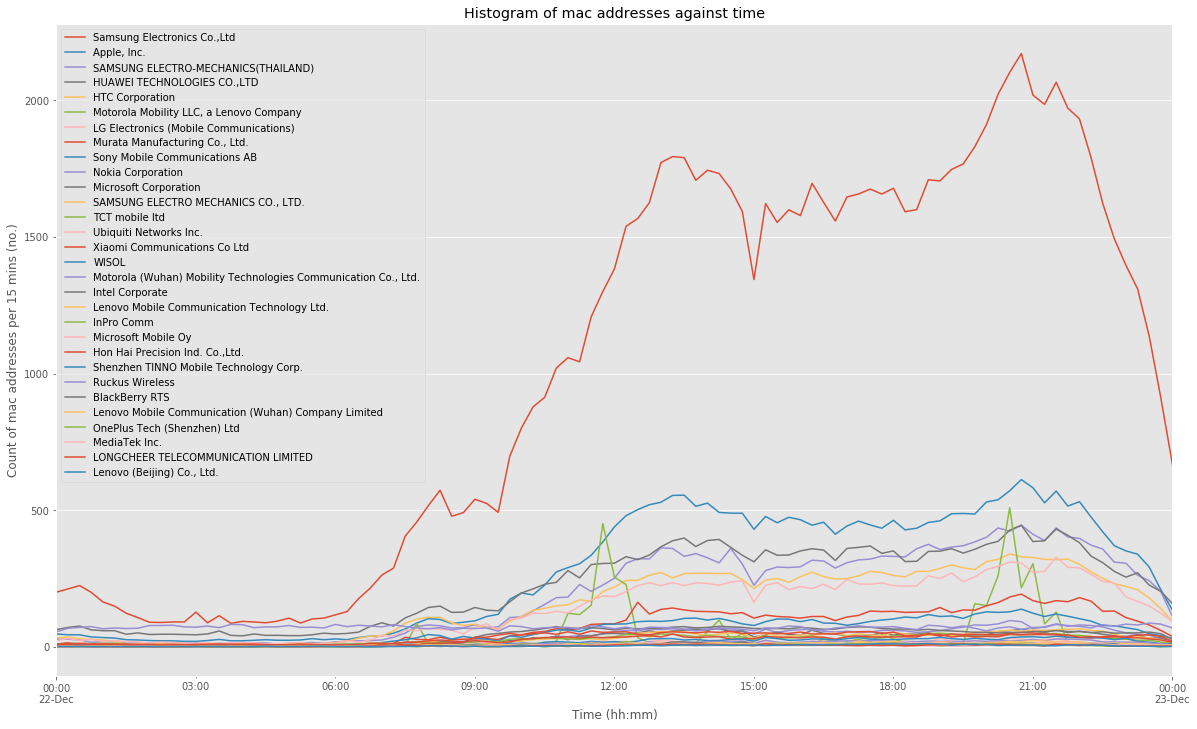

In [111]:
minute_resolution = '15'

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 12))

for company in signal_df.groupby('mac_address').head(1).manufacturer.value_counts()[:30].index:
    company_signal_df = signal_df[signal_df.manufacturer == company]
    company_signal_df.date_time = company_signal_df.date_time.dt.round(minute_resolution + 'min')
    company_signal_time_df = company_signal_df.groupby('date_time').mac_address.nunique().to_frame()
    company_signal_time_df.rename(columns={'mac_address': company}, inplace=True)

    ax = company_signal_time_df.plot(ax=axes)
    ax.set_title('Histogram of mac addresses against time')
    ax.set_xlabel('Time (hh:mm)')
    ax.set_ylabel('Count of mac addresses per {} mins (no.)'.format(minute_resolution));

c:\users\tvb\envs\venv-msci\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


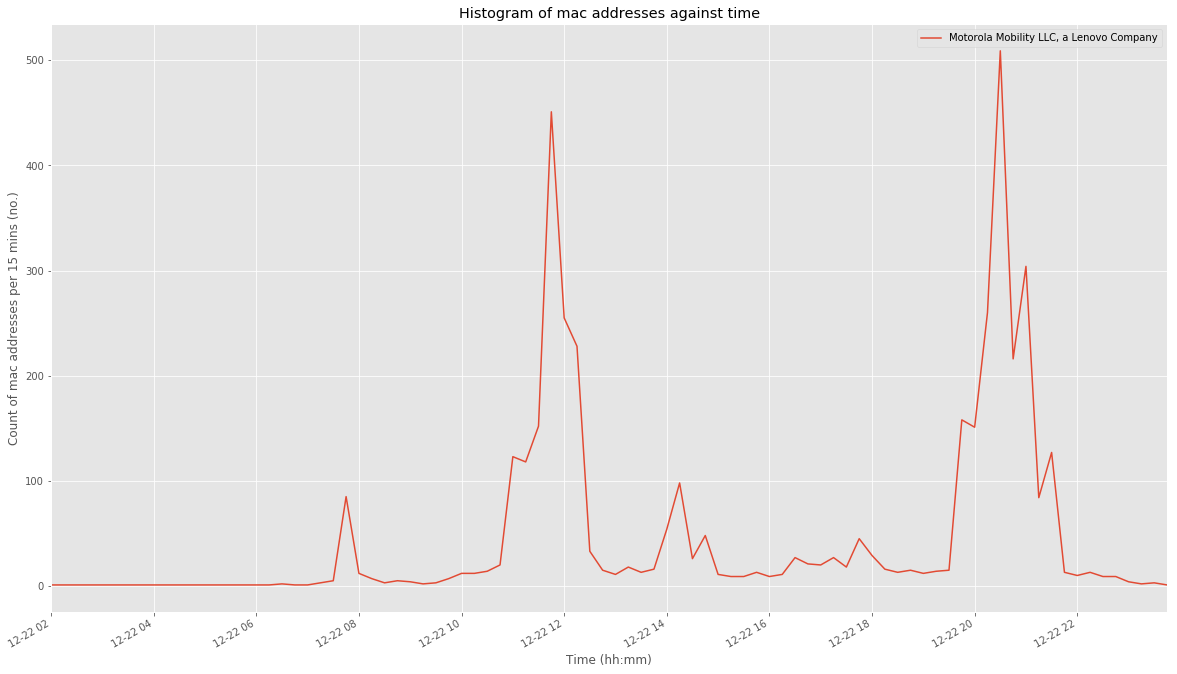

In [119]:
minute_resolution = '15'

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 12))

company = 'Motorola Mobility LLC, a Lenovo Company'

company_signal_df = signal_df[signal_df.manufacturer == company]
company_signal_df.date_time = company_signal_df.date_time.dt.round(minute_resolution + 'min')
company_signal_time_df = company_signal_df.groupby('date_time').mac_address.nunique().to_frame()
company_signal_time_df.rename(columns={'mac_address': company}, inplace=True)

ax = company_signal_time_df.plot(ax=axes)
ax.set_title('Histogram of mac addresses against time')
ax.set_xlabel('Time (hh:mm)')
ax.set_ylabel('Count of mac addresses per {} mins (no.)'.format(minute_resolution));

In [138]:
signal_clean_df = remove_sparse_data(signal_df, 100)

c:\users\tvb\envs\venv-msci\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
c:\users\tvb\envs\venv-msci\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


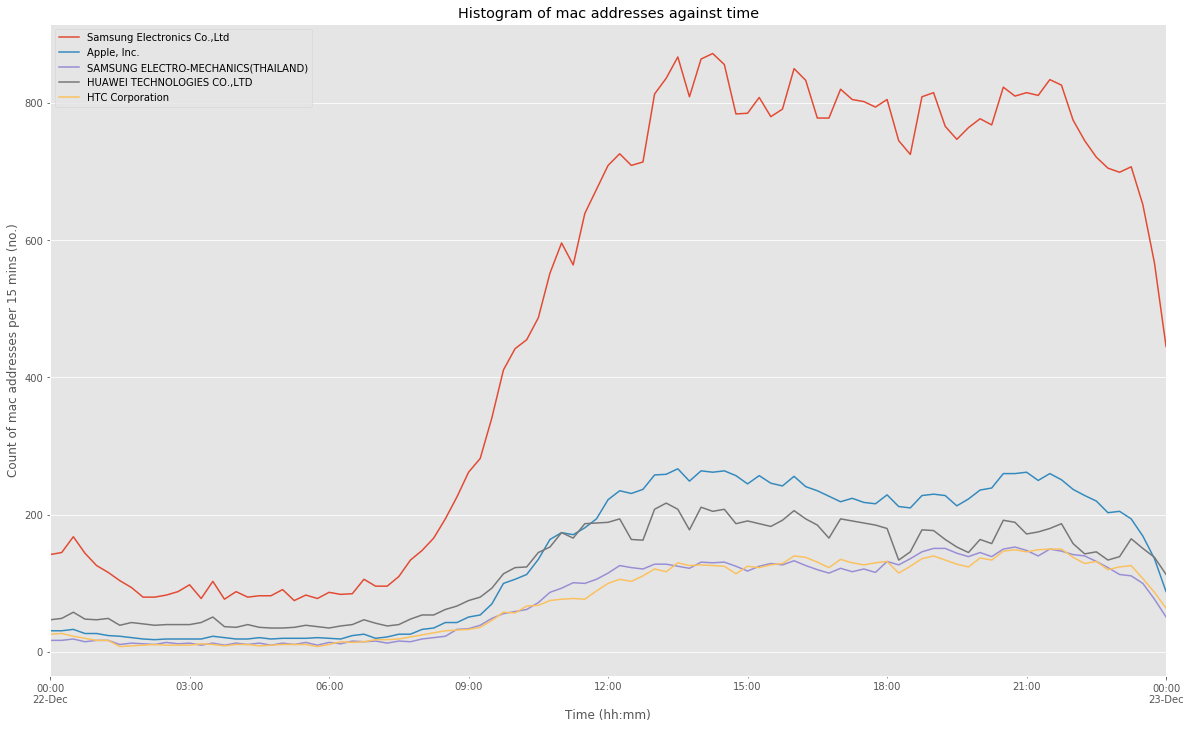

In [139]:
minute_resolution = '15'

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 12))

for company in signal_clean_df.groupby('mac_address').head(1).manufacturer.value_counts()[:5].index:
    company_signal_df = signal_clean_df[signal_df.manufacturer == company]
    company_signal_df.date_time = company_signal_df.date_time.dt.round(minute_resolution + 'min')
    company_signal_time_df = company_signal_df.groupby('date_time').mac_address.nunique().to_frame()
    company_signal_time_df.rename(columns={'mac_address': company}, inplace=True)

    ax = company_signal_time_df.plot(ax=axes)
    ax.set_title('Histogram of mac addresses against time')
    ax.set_xlabel('Time (hh:mm)')
    ax.set_ylabel('Count of mac addresses per {} mins (no.)'.format(minute_resolution));

## Import mac address data frame

This dataframe has each mac address with key quantities such as radius of gyration etc.

In [142]:
mac_address_df = pd.read_csv('../data/mac_address_features.csv')

In [148]:
signal_clean_df = remove_sparse_data(signal_df, 10)

good_mac_addresses = mac_address_df.mac_address[mac_address_df.gyration > 40].tolist()
signal_clean_df = signal_clean_df[signal_clean_df.mac_address.isin(good_mac_addresses)]

## Mac address against time

c:\users\tvb\envs\venv-msci\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
c:\users\tvb\envs\venv-msci\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


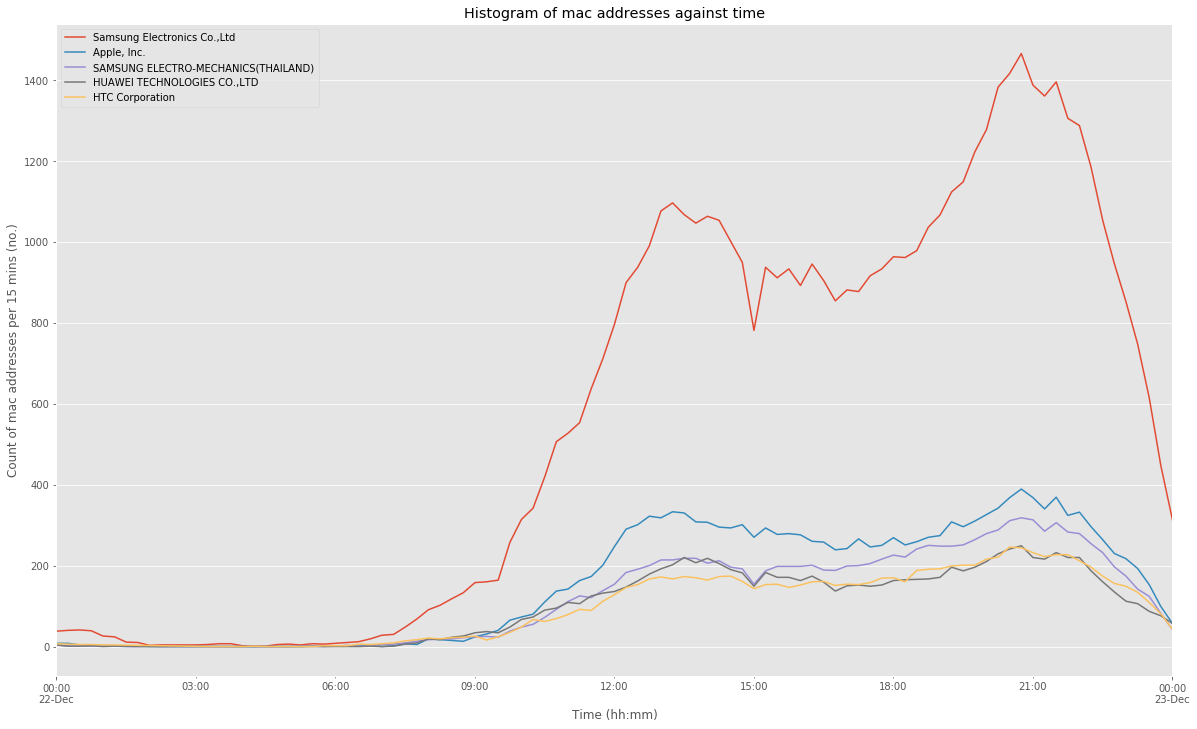

In [149]:
minute_resolution = '15'

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 12))

for company in signal_clean_df.groupby('mac_address').head(1).manufacturer.value_counts()[:5].index:
    company_signal_df = signal_clean_df[signal_df.manufacturer == company]
    company_signal_df.date_time = company_signal_df.date_time.dt.round(minute_resolution + 'min')
    company_signal_time_df = company_signal_df.groupby('date_time').mac_address.nunique().to_frame()
    company_signal_time_df.rename(columns={'mac_address': company}, inplace=True)

    ax = company_signal_time_df.plot(ax=axes)
    ax.set_title('Histogram of mac addresses against time')
    ax.set_xlabel('Time (hh:mm)')
    ax.set_ylabel('Count of mac addresses per {} mins (no.)'.format(minute_resolution));